In [6]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import random
import matplotlib.pyplot as plt

In [ ]:
class Profile:
  def __init__(self, preferences):
      self._preferences = preferences
  def agents_num(self):
        return len(self._preferences)
  def candidates_num(self):
      return len(self._preferences[0])
  def candidates_names(self):
      return sorted(self._preferences[0])    
  def first_pref(self):
      return [x[0] for x in self.k_first_pref(1)]
  def k_first_pref(self, k):
      return [item[0:k] for item in self._preferences]
  def pref(self):
      return [item[:] for item in self._preferences]
  def candidate_positions(self, candidate):
      list_positions = []
      for preference in self._preferences:
          list_positions.append(preference.index(candidate))
      return list_positions
  def candidate_Borda_positions(self, candidate):
      m = self.candidates_num()
      return [m-1-pos for pos in self.candidate_positions(candidate)]

      
def k_approval_scores(k, m):
    return [1 for i in range(k)]+[0 for i in range(m-k)]

def trunc_Borda_scores(k, m):
    return [*range(k, 0, -1)]+[0 for i in range(m-k)]
  
def garmonic_scores(m):
    return [1/i for i in range(1, m+1)]

def geometric_scores(p, m):
    if p > 1:
        return [p**(m-i) for i in range(1, m+1)]
    if p == 1:
        return [m-i for i in range(1, m+1)]
    if p < 1:
        return [(1 - p**(m-i)) for i in range(1, m+1)]
  
def dict_positions(profile):
    candidates_names = profile.candidates_names()
    candidates_num = profile.candidates_num()
    list_of_lists_positions = [profile.candidate_positions(candidate) for candidate in candidates_names]
    list_dict = []
    for each_list in list_of_lists_positions:
        dict_count_positions = {}
        for j in range(candidates_num):
            dict_count_positions[j] = 0
        for value in each_list:
            dict_count_positions[value] = dict_count_positions.get(value, 0) + 1
        list_dict.append(dict_count_positions)
    return dict(zip(candidates_names, list_dict))

def dict_scores(profile, scoring_vector):
    candidates_names = profile.candidates_names()
    dict_positions1 = dict_positions(profile)
    matrix_positions = []
    for candidate in candidates_names:
        matrix_positions.append(list(dict_positions1.get(candidate).values()))
    return dict(zip(candidates_names, np.dot(np.array(matrix_positions), np.array(scoring_vector))))

def max_key_in_dict(dictionary):
    max_list = []
    m = max(dictionary.keys(), key=(lambda k: dictionary[k]))
    for key in dictionary:
        if dictionary[key] == dictionary[m]:
            max_list.append(key)
    return max_list

def scoring_rule(profile, scoring_vector):
    return max_key_in_dict(dict_scores(profile, scoring_vector))

def plurality(profile):
    scores = k_approval_scores(1, profile.candidates_num())
    return scoring_rule(profile, scores)

def k_approval(profile, k):
    scores = k_approval_scores(k, profile.candidates_num())
    return scoring_rule(profile, scores)

def borda(profile):
    m = profile.candidates_num()
    scores = trunc_Borda_scores(m-1, m)
    return scoring_rule(profile, scores)

def borda_truncated(profile, v):
    scores = trunc_Borda_scores(v, profile.candidates_num())
    return scoring_rule(profile, scores)

def harmonic(profile):
    m = profile.candidates_num()
    scores = garmonic_scores(m)
    return scoring_rule(profile, scores)

def geometric(profile, p):
    m = profile.candidates_num()
    scores = geometric_scores(p,m)
    return scoring_rule(profile, scores)

def generate_IC_preferences(voters, candidates):
    i = 1
    preferences = []
    while i <= voters:
        rng = default_rng()
        num = list(rng.choice(candidates, size= candidates, replace=False))
        preferences.append(num)
        i += 1
    return preferences
    return Profile(preferences)

def naming_function(names_num, nested_list):
    names = [*range(0, names_num)]
    return [dict(zip(names, each_list)) for each_list in nested_list]

def euclidean_preferences(n, m, k):
    voters = [[random.uniform(-1, 1) for i in range(k)] for a in range(n)]
    candidates = [[random.uniform(-1, 1) for i in range(k)] for a in range(m)]
    distances_list = [[euclidean_distance(voter, candidate) for candidate in candidates] for voter in voters]
    unordered_named_nested_list = naming_function(len(candidates), distances_list)
    
    profile = []
    for i in unordered_named_nested_list:
        sorted_distance = sorted(i.items(), key = lambda item: item[1])
        preferences = []
        for j in sorted_distance:
            candidate_name = j[0]
            preferences.append(candidate_name)
        profile.append(preferences)
    return Profile(profile)

def borda_utility(profile, winner):
    return sum(profile.candidate_Borda_positions(winner))

def rawls_utility(profile, winner):
    return min(profile.candidate_Borda_positions(winner))

def nash_utility(profile, winner):
    return np.prod(profile.candidate_Borda_positions(winner))

def euclidean_distance(point_1, point_2):
    return sum((np.array(point_1) - np.array(point_2))**2)  

class Agent:
  def __init__(self, preferences, happiness):
    self.happiness = happiness
    self.preferences = preferences
    self.history = []

class Room:
  def __init__(self, generate_new_agent, play_track, update_happiness, happiness_threshold, number_of_genres):
    self.generate_new_agent = generate_new_agent
    self.play_track = play_track
    self.update_happiness = update_happiness
    self.happiness_threshold = happiness_threshold
    self.number_of_genres = number_of_genres
    self.agents = []
    self.history = []
    self.all_happy = []
    self.average_happiness = []
    self.number_of_people = []
    
  def get_profile(self):
    preferences = [agent.preferences for agent in self.agents]
    return Profile(preferences)
    
  def update_agents(self):
    for agent in self.agents:
      self.update_happiness(agent, agent.history)
    self.agents = [agent for agent in self.agents if agent.happiness>= self.happiness_threshold]
    
  def next_period(self):
    new_agent = self.generate_new_agent(self.number_of_genres)
    self.agents.append(new_agent)
    new_track = self.play_track(self.get_profile())
    self.history.append(new_track)
    for agent in self.agents:
      agent.history.append(new_track)
    self.update_agents()
    self.average_happy()
    self.number_of_quest()
    self.sum_happiness()
    

  def sum_happiness(self):
    sum_happ = 0
    for agent in self.agents:
      sum_happ += agent.happiness
    self.all_happy.append(sum_happ)
    return sum_happ

  def average_happy(self):
    sum_happ = 0
    for agent in self.agents:
      sum_happ += agent.happiness
    average_hap = 0 if len(self.agents)==0 else sum_happ/len(self.agents)
    self.average_happiness.append(average_hap)

  def number_of_quest(self):
    self.number_of_people.append(len(self.agents))
    return len(self.agents)
    
  def print_state(self):
      print("Tracks played: " + str(self.history))
      print("Currently in room:")
      for agent in self.agents:
        print(str(agent.preferences) + ", happiness: " + str(agent.happiness))
      print("all happy: " + str(self.all_happy[-1]))
      print("average happy: " + str(self.average_happiness[-1]))
      print("number of people: " + str(self.number_of_people[-1]))


  
def play_michael_jackson(profile):
  the_king_of_pop = 0
  return the_king_of_pop

def top_hits(agent, history):
  for tied_songs in history:
    if agent.preferences[0] in tied_songs:
      agent.happiness +=1

def borda_happy(agent, history):
  score = 0
  for songs in history:
    for n in range(len(agent.preferences)):
      if agent.preferences[n] ==songs[0]:
        score += len(agent.preferences) - n - 1
        agent.happiness += score
  
def everyone_is_unique(m):
  initial_happiness = 0
  preferences = list(range(0,m))
  return Agent(preferences, initial_happiness)

def IC_preference(m):
  initial_happiness = 0
  rng = default_rng()
  preferences = list(rng.choice(m, size = m, replace=False))
  return Agent(preferences, initial_happiness)

def Euclidean_preferences(n, m, k):
  initial_happiness = 0
  voters = [[random.uniform(-1, 1) for i in range(k)] for a in range(n)]
  candidates = [[random.uniform(-1, 1) for i in range(k)] for a in range(m)]
  distances_list = [[euclidean_distance(voter, candidate) for candidate in candidates] for voter in voters]
  unordered_named_nested_list = naming_function(len(candidates), distances_list)
  profile = []
  for i in unordered_named_nested_list:
      sorted_distance = sorted(i.items(), key = lambda item: item[1])
      preferences = []
      for j in sorted_distance:
          candidate_name = j[0]
          preferences.append(candidate_name)
      profile.append(preferences)
  return Agent(preferences, initial_happiness)

def Euclidean_candidates(m,k):
  return [[random.uniform(-1, 1) for i in range(k)] for a in range(m)]

def Euclidean_agent(candidates, k):
  voter = [random.uniform(-1, 1) for i in range(k)]
  distances=[euclidean_distance(voter, candidate) for candidate in candidates]
  unordered_named_nested_list = naming_function(len(candidates), [distances])
  sorted_distance = sorted(unordered_named_nested_list[0].items(), key = lambda item: item[1])
  preferences = []
  for j in sorted_distance:
      candidate_name = j[0]
      preferences.append(candidate_name)
  return Agent(preferences, 0)
  
def play_michael_jackson(profile):
  the_king_of_pop = 0
  return the_king_of_pop

def top_hits(agent, history):
  for tied_songs in history:
    if agent.preferences[0] in tied_songs:
      agent.happiness +=1

def borda_happy(agent, history):
  score = 0
  for songs in history:
    for n in range(len(agent.preferences)):
      if agent.preferences[n] ==songs[0]:
        score += len(agent.preferences) - n - 1
        agent.happiness += score

def article_happy_nul(agent, history):
  songs = history[-1]
  song_rank = agent.preferences.index(songs[0])
  score = len(agent.preferences) - song_rank - 1
  agent.happiness = agent.happiness* 0.8
  agent.happiness += score/len(agent.preferences)

def i_dont_like_the_drugs_but_the_drugs_like_me(agent, history):
  agent.happiness += 1
  
if __name__ == "__main__":
  m=5
  k=3
  candidates = Euclidean_candidates(m,k)
  # plurality

  averages_plurality_ic = []
  summas_plurality_ic = []
  number_of_quests_plurality_ic = []
  th_range =  np.arange(0,1,0.25)
  for th in th_range:
    room = Room(IC_preference, plurality, article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      #room.print_state()
      #print("")
    summas_plurality_ic.append(room.all_happy)
    averages_plurality_ic.append(room.average_happiness)
    number_of_quests_plurality_ic.append(room.number_of_people)
  # borda
  averages_borda_ic = []
  summas_borda_ic = []
  number_of_quests_borda_ic = []
  th_range =  np.arange(0,1,0.25)
  for th in th_range:
    room = Room(IC_preference, borda, article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      #room.print_state()
      #print("")
    summas_borda_ic.append(room.all_happy)
    averages_borda_ic.append(room.average_happiness)
    number_of_quests_borda_ic.append(room.number_of_people)
  # lambda y: k_approval(y,k=2)
  averages_app_ic = []
  summas_app_ic = []
  number_of_quests_app_ic = []
  th_range =  np.arange(0,1,0.25)
  for th in th_range:
    room = Room(IC_preference, lambda y: k_approval(y,k=2), article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      #room.print_state()
      #print("")
    summas_app_ic.append(room.all_happy)
    averages_app_ic.append(room.average_happiness)
    number_of_quests_app_ic.append(room.number_of_people)

  # lambda y: borda_truncated(y, 2)
  averages_borda_th_ic = []
  summas_borda_th_ic = []
  number_of_quests_borda_th_ic = []
  th_range =  np.arange(0,5,0.5)
  for th in th_range:
    room = Room(IC_preference, lambda y: borda_truncated(y, 3), article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      room.print_state()
      #print("")
    summas_borda_th_ic.append(room.all_happy)
    averages_borda_th_ic.append(room.average_happiness)
    number_of_quests_borda_th_ic.append(room.number_of_people)
  # harmonic
  averages_harmonic = []
  summas_harmonic = []
  number_of_quests_harmonic = []
  th_range =  np.arange(0,5,0.5)
  for th in th_range:
    room = Room(IC_preference, harmonic, article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      room.print_state()
      #print("")
    summas_harmonic.append(room.all_happy)
    averages_harmonic.append(room.average_happiness)
    number_of_quests_harmonic.append(room.number_of_people)
  # lambda z: geometric(z, 0.8)
  averages_small_geom_ic = []
  summas_small_geom_ic = []
  number_of_quests_small_geom_ic = []
  th_range =  np.arange(0,1,0.25)
  for th in th_range:
    room = Room(IC_preference, lambda z: geometric(z, 0.8), article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      #room.print_state()
      #print("")
    summas_small_geom_ic.append(room.all_happy)
    averages_small_geom_ic.append(room.average_happiness)
    number_of_quests_small_geom_ic.append(room.number_of_people)
  # lambda z: geometric(z, 1.8)
  averages_big_geom_ic = []
  summas_big_geom_ic = []
  number_of_quests_big_geom_ic = []
  th_range =  np.arange(0,1,0.25)
  for th in th_range:
    room = Room(IC_preference, lambda z: geometric(z, 1.8), article_happy_nul, th, m)
    for i in range(0,100):
      #print(th)
      room.next_period()
      #room.print_state()
      #print("")
    summas_big_geom_ic.append(room.all_happy)
    averages_big_geom_ic.append(room.average_happiness)
    number_of_quests_big_geom_ic.append(room.number_of_people)

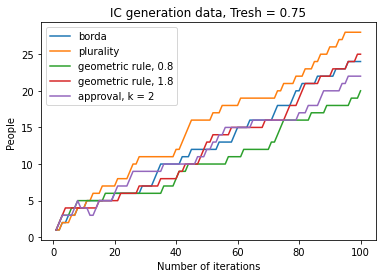

In [7]:
plt.plot(range(1,101), number_of_quests_borda_ic[3], label='borda')
plt.plot(range(1,101), number_of_quests_plurality_ic[3], label='plurality')
plt.plot(range(1,101), number_of_quests_small_geom_ic[3], label='geometric rule, 0.8')
plt.plot(range(1,101), number_of_quests_big_geom_ic[3], label='geometric rule, 1.8')
#plt.plot(range(1,101), number_of_quests_harmonic[3], label='harmonic')

plt.plot(range(1,101), number_of_quests_app_ic[3], label='approval, k = 2')
#plt.plot(range(1,101), number_of_quests_borda_th_ic[3], label='thunk borda 3')

plt.xlabel('Number of iterations')
# naming the y axis
plt.ylabel('People ')
# giving a title to my graph
plt.title('IC generation data, Tresh = 0.75')
plt.legend()
plt.show()

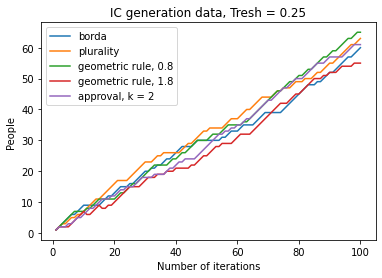

In [8]:
plt.plot(range(1,101), number_of_quests_borda_ic[1], label='borda')
plt.plot(range(1,101), number_of_quests_plurality_ic[1], label='plurality')
plt.plot(range(1,101), number_of_quests_small_geom_ic[1], label='geometric rule, 0.8')
plt.plot(range(1,101), number_of_quests_big_geom_ic[1], label='geometric rule, 1.8')
#plt.plot(range(1,101), number_of_quests_harmonic[1], label='harmonic')

plt.plot(range(1,101), number_of_quests_app_ic[1], label='approval, k = 2')
#plt.plot(range(1,101), number_of_quests_borda_th_ic[1], label='thunk borda 3')

plt.xlabel('Number of iterations')
# naming the y axis
plt.ylabel('People ')
# giving a title to my graph
plt.title('IC generation data, Tresh = 0.25')
plt.legend()
plt.show()

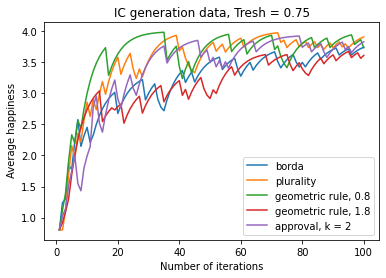

In [9]:
plt.plot(range(1,101), averages_borda_ic[3], label='borda')
plt.plot(range(1,101), averages_plurality_ic[3], label='plurality')
plt.plot(range(1,101), averages_small_geom_ic[3], label='geometric rule, 0.8')
plt.plot(range(1,101), averages_big_geom_ic[3], label='geometric rule, 1.8')
#plt.plot(range(1,101), averages_harmonic[3], label='harmonic')

plt.plot(range(1,101), averages_app_ic[3], label='approval, k = 2')
#plt.plot(range(1,101), averages_borda_th_ic[3], label='thunk borda 3')

plt.xlabel('Number of iterations')
# naming the y axis
plt.ylabel(' Average happiness')
# giving a title to my graph
plt.title('IC generation data, Tresh = 0.75')
plt.legend()
plt.show()

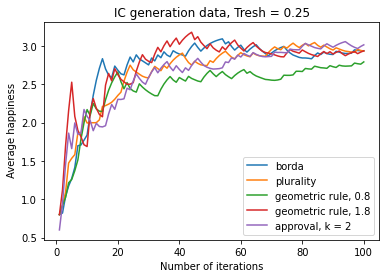

In [10]:
plt.plot(range(1,101), averages_borda_ic[1], label='borda')
plt.plot(range(1,101), averages_plurality_ic[1], label='plurality')
plt.plot(range(1,101), averages_small_geom_ic[1], label='geometric rule, 0.8')
plt.plot(range(1,101), averages_big_geom_ic[1], label='geometric rule, 1.8')
#plt.plot(range(1,101), averages_harmonic[1], label='harmonic')

plt.plot(range(1,101), averages_app_ic[1], label='approval, k = 2')
#plt.plot(range(1,101), averages_borda_th_ic[1], label='thunk borda 3')

plt.xlabel('Number of iterations')
# naming the y axis
plt.ylabel(' Average happiness')
# giving a title to my graph
plt.title('IC generation data, Tresh = 0.25')
plt.legend()
plt.show()